---
title: 'Metropolis Hastings Sampler From Scratch'
date: 2022-10-08
author: 'Gabriel Stechschulte'
draft: false
math: true
categories: ['probabilistic-programming']
---

<!--eofm-->

### Main Idea

Metropolis-Hastings (MH) is one of the simplest kinds of MCMC algorithms. The idea with MH is that at each step, we propose to move from the current state $x$ to a new state $x'$ with probability $q(x'|x)$, where $q$ is the **proposal distribution**. The user is free to choose the proposal distribution and the choice of the proposal is dependent on the form of the target distribution. Once a proposal has been made to move to $x'$, we then decide whether to **accept** or **reject** the proposal according to some rule. If the proposal is accepted, the new state is $x'$, else the new state is the same as the current state $x$. 

Proposals can be **symmetric** and **asymmetric**. In the case of symmetric proposals $q(x'|x) = q(x|x')$, the acceptance probability is given by the rule:

$$A = min(1, \frac{p^*(x')}{p^*(x)})$$

The fraction is a ratio between the probabilities of the proposed state $x'$ and current state $x$. If $x'$ is more probable than $x$, the ratio is $> 1$, and we move to the proposed state. However, if $x'$ is less probable, we may still move there, depending on the relative probabilities. If the relative probabilities are similar, we may code _exploration_ into the algorithm such that they go in the opposite direction. This helps with the greediness of the original algorithm—only moving to more probable states. 

### The Algorithm

1. Initialize $x^0$

2. for $s = 0, 1, 2, 3, ...$ do:
   - Define $x = x^s$
   - Sample $x' \sim q(x'|x)$ where $q$ is the user's proposal distribution
   - Compute the acceptance probability given by:
   - $p_a(x_{t+1}|x_i) = min(1, \frac{p(x_{i+1})q(x_i | x_{i+1})}{p(x_i)q(x_{i+1}|x_I)})$

3. Compute $A = min(1, \alpha)$

4. Sample $u \sim U(0, 1)$

5. Set new sample to:
$x^{s+1} = 
\left\{
\begin{array}{ll}
    x' & \quad \text{if} \quad u \leq A(\text{accept}) \\
    x & \quad \text{if} \quad x > A(\text{reject}) \\
\end{array}
\right.$


### Random Walk Metropolis-Hastings

The random walk metropolis-hastings (RWMH) corresponds to MH with a Gaussian propsal distribution of the form:

$$q(x'|x) = \mathcal{N}(x'|x, \tau^2 I)$$

Below, I implement the RWMH for sampling from a 1-dimenensional mixture of Gaussians (implemented using the `MixtureSameFamily` PyTorch class) with the following parameters:

- $\mu = -20, 20$
- Mixture component probability $= 0.3, 0.7$
- $\sum = 10, 10$


In [1]:
#| echo: false
import torch
from torch import distributions as dist
import matplotlib.pyplot as plt
import argparse
import warnings
warnings.filterwarnings("ignore")

In [29]:
#| code-fold: true
def plot(distribution, trace_history, xmin, xmax, n_iterations, n_evals=500):

    x_evals = torch.linspace(xmin, xmax, n_evals)
    evals = torch.exp(distribution.log_prob(x_evals))
    
    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(torch.arange(n_iterations), trace_history)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Sampled Value')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot(torch.arange(n_iterations), trace_history)
    ax.plot(torch.zeros(n_evals), x_evals, evals)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Sampled Value')

    fig.suptitle('Random Walk Metropolis-Hastings')
    plt.show()


def true_distribution(mixture_probs, mus, scales):

    return dist.MixtureSameFamily(
        mixture_distribution=dist.Categorical(probs=mixture_probs),
        component_distribution=dist.Normal(loc=mus, scale=scales)
        )

In [30]:
def metropolis_hasting(x0, tau, mixture, n_iterations, rng_key=None):
    """
    implements the random walk metropolis-hasting algorithm
    """

    x_current = x0
    x_samples = torch.zeros(n_iterations)
    x_samples[0] = x_current
    cnt_acceptance = 0
     
    for n in range(1, n_iterations):
        
        # datum of proposed state x'
        x_candidate = x_current + tau * dist.Normal(loc=0, scale=1).sample()
        # probs. of proposed state x'
        p_candidate = torch.exp(mixture.log_prob(x_candidate))
        # probs. of current state x
        p_current = torch.exp(mixture.log_prob(x_current))
        
        # acceptance formula
        alpha = p_candidate / p_current
        probs_accept = min(1, alpha)
        
        # sample u ~ U(0, 1)
        u = dist.Uniform(0, 1).sample()

        if u >= probs_accept:
            x_current = x_current
        else:
            x_current = x_candidate
            cnt_acceptance += 1

        x_samples[n] = x_current

    acceptence_ratio = cnt_acceptance / n_iterations
    print('---- statistics ----')
    print(f'acceptance rate = {acceptence_ratio}')

    return x_samples


def main(args):

    # initial parameter value
    x0 = torch.tensor(20.)

    # mixture dist. parameters
    mixture_probs = torch.tensor([0.3, 0.7])
    mus = torch.tensor([-20., 20.])
    scales = torch.tensor([10., 10.])

    n_iters = args.iters
    tau = torch.tensor(args.tau)

    mixture_distribution = true_distribution(mixture_probs, mus, scales)
    x_samples = metropolis_hasting(x0, tau, mixture_distribution, n_iters)

    plot(mixture_distribution, x_samples, -100, 100, n_iters)

---- statistics ----
acceptance rate = 0.803


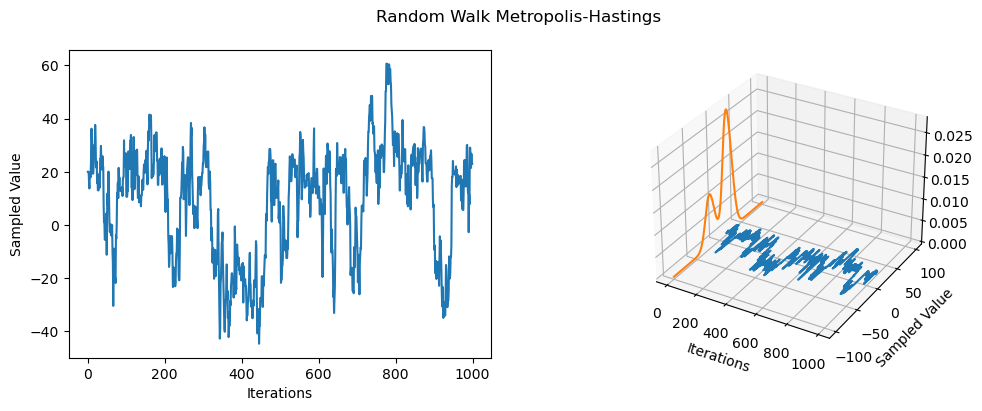

In [39]:
parser = argparse.ArgumentParser(description='rw-mh')
parser.add_argument('--iters', type=int, default=1000)
parser.add_argument('--tau', type=float, default=8.)
args = parser.parse_args("")

main(args)

### Results

The mixture distribution can be tricky to sample from as it is has more than one model, i.e., it is a bimodal distribution. However, we can see that the RWMH spends time sampling from both component distributions, albeit, the distribution with the higher probability more. Due to the random search based perturbations (random walk), the sampler seems to randomly jump from component to component, showing that the chain is not _sticky_. Additionally, the acceptance rate is $0.803$ indicating that about $80\%$ of new proposals were accepted.